# Depth estimation of mono-camera images for Visual SLAM 

In [3]:
# !unzip example_dataset.zip
tf.__version__

'2.4.1'

In [2]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D, Input
from keras.models import Model
from keras.applications import ResNet50
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
class models(object):
    def __init__(self, input_shape=(256, 256, 3)):
        self.model = self.UNet(image_size=128)
        
    def down_block(self, x, filters, kernel_s = (3,3), 
                padding_ = 'same', strides_ = 1, 
                activation_ = 'relu'):

        conv1_layer = Conv2D(filters, 
                            kernel_size=kernel_s, 
                            padding=padding_, 
                            strides=strides_, 
                            activation=activation_)(x)

        conv2_layer = Conv2D(filters, 
                            kernel_size=kernel_s, 
                            padding=padding_, 
                            strides=strides_, 
                            activation=activation_)(conv1_layer)

        pooling_layer = MaxPool2D((2,2), strides=(2,2))(conv2_layer)

        return conv2_layer, pooling_layer

    def up_block(self, x, skip, filters, kernel_s = (3,3), 
                        padding_ = 'same', strides_ = 1, 
                        activation_ = 'relu'):

        up_sampling_1 = UpSampling2D((2,2))(x)
        concat1 = Concatenate()([up_sampling_1, skip])

        conv1_layer = Conv2D(filters, 
                            kernel_size=kernel_s, 
                            padding=padding_, 
                            strides=strides_, 
                            activation=activation_)(concat1)

        conv2_layer = Conv2D(filters, 
                            kernel_size=kernel_s, 
                            padding=padding_, 
                            strides=strides_, 
                            activation=activation_)(conv1_layer)

        return conv2_layer

    def bottleneck(self, x, filters, kernel_s = (3,3), 
                padding_ = 'same', strides_ = 1, 
                activation_ = 'relu'):

        conv1_layer = Conv2D(filters, 
                            kernel_size=kernel_s, 
                            padding=padding_, 
                            strides=strides_, 
                            activation=activation_)(x)

        conv2_layer = Conv2D(filters, 
                            kernel_size=kernel_s, 
                            padding=padding_, 
                            strides=strides_, 
                            activation=activation_)(conv1_layer)
        return conv2_layer
    
    def UNet(self, image_size, filters = [16, 32, 64, 128, 256]):
        inputs = keras.layers.Input([image_size, image_size, 3])

        p0 = inputs
        c1, p1 = self.down_block(p0, filters[0]) # 128 -> 64
        c2, p2 = self.down_block(p1, filters[1]) # 64  -> 32
        c3, p3 = self.down_block(p2, filters[2]) # 32  -> 16
        c4, p4 = self.down_block(p3, filters[3]) # 16  -> 8

        bn = self.bottleneck(p4, filters[4])

        u1 = self.up_block(bn, c4, filters[3]) # 8  -> 16
        u2 = self.up_block(u1, c3, filters[2]) # 16 -> 32
        u3 = self.up_block(u2, c2, filters[1]) # 32 -> 64
        u4 = self.up_block(u3, c1, filters[0]) # 64 -> 128

        outputs = Conv2D(1, kernel_size=(1,1), padding='same', activation='sigmoid')(u4)
        mdl = keras.models.Model(inputs, outputs)

        return mdl

    # def UNet_resnet50(self, input_shape):
    #     from keras.applications import ResNet50
    #     inputs = keras.layers.Input(input_shape)

    #     '''Load pre-trained resnet50 '''
    #     resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs) # no classifier layers needed.

    #     ''' Encoder '''
    #     s1 = resnet50.get_layer("input_1").output          #128
    #     s2 = resnet50.get_layer("conv1_relu").output        #64, 64  filters
    #     s3 = resnet50.get_layer("conv2_block3_out").output  #32, 256 filters
    #     s4 = resnet50.get_layer("conv3_block4_out").output  #16, 512 filters

    #     ''' Bottleneck '''
    #     pooling_layer = MaxPool2D((2,2), strides=(2,2))(s4)
    #     bn = self.bottleneck(pooling_layer, filters = 1024)

    #     ''' Decoder '''
    #     d1 = self.up_block(bn, s4, 1024)
    #     d2 = self.up_block(d1, s3, 512)
    #     d3 = self.up_block(d2, s2, 256)
    #     d4 = self.up_block(d3, s1, 64)

    #     outputs = Conv2D(1, kernel_size=(1,1), padding='same', activation='sigmoid')(d4)
    #     mdl = keras.models.Model(inputs, outputs)

    #     return mdl
     

In [5]:
class dataloarder_rgbd(tf.keras.utils.Sequence): #
    def __init__(self, dataset_path, batch_size, image_size=128, shuffle=False):
        self.rgb_images = os.listdir(str(str(dataset_path)+'/rgb/'))
        self.rgb_images.sort()
        self.rgb_images = [str(str(dataset_path)+'/rgb/') + file for file in self.rgb_images]
        
        self.depth_images = os.listdir(str(str(dataset_path)+'/depth/'))
        self.depth_images.sort()
        self.depth_images = [str(str(dataset_path)+'/depth/') + file for file in self.depth_images]

        # Shuffle later
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = image_size
        self.min_depth = 999999
        self.max_depth = 0
        for depthimg in self.depth_images:
            depth = cv2.imread(depthimg, -1)
            depth = cv2.resize(depth, (self.image_size, self.image_size))
            mx = np.max(depth)
            mn = np.min(depth)
            if mx > self.max_depth:
                self.max_depth = mx
            if mn < self.min_depth:
                self.min_depth = mn
        self.on_epoch_end()

    def on_epoch_end(self):
        None
    
    def __len__(self):
        return len(self.rgb_images) // self.batch_size

    def __getitem__(self, index):
        rgb_batch = self.rgb_images[index * self.batch_size:(index + 1) * self.batch_size]
        depth_batch = self.depth_images[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(rgb_batch, depth_batch)
        return X, y

    def __get_data(self, rgb_imgs, depth_imgs):
        rgb_images=[]
        depth_images=[]
        for rgb_file in rgb_imgs:
            rbg_img = cv2.imread(rgb_file) #, cv2.IMREAD_COLOR)
            rgb_img = cv2.resize(rbg_img, (self.image_size, self.image_size))
            rgb_img = rgb_img/float(255.0)
            rgb_images.append(rgb_img)
            
        for depth_file in depth_imgs:
            depth_image = cv2.imread(depth_file, -1)
            depth_image = cv2.resize(depth_image, (self.image_size, self.image_size))
            depth_image = (depth_image-self.min_depth)/(self.max_depth - self.min_depth)
            depth_images.append(depth_image)
            
        return np.array(rgb_images), np.array(depth_images)

In [7]:
import sys
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

dataset_path = '/content/'
# dtloader = dataloarder_rgbd(dataset_path,10)

checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor='loss',
                             save_best_only=True)

m = models(input_shape=(128, 128, 3))
m.model.compile(optimizer='adam', loss='mse')

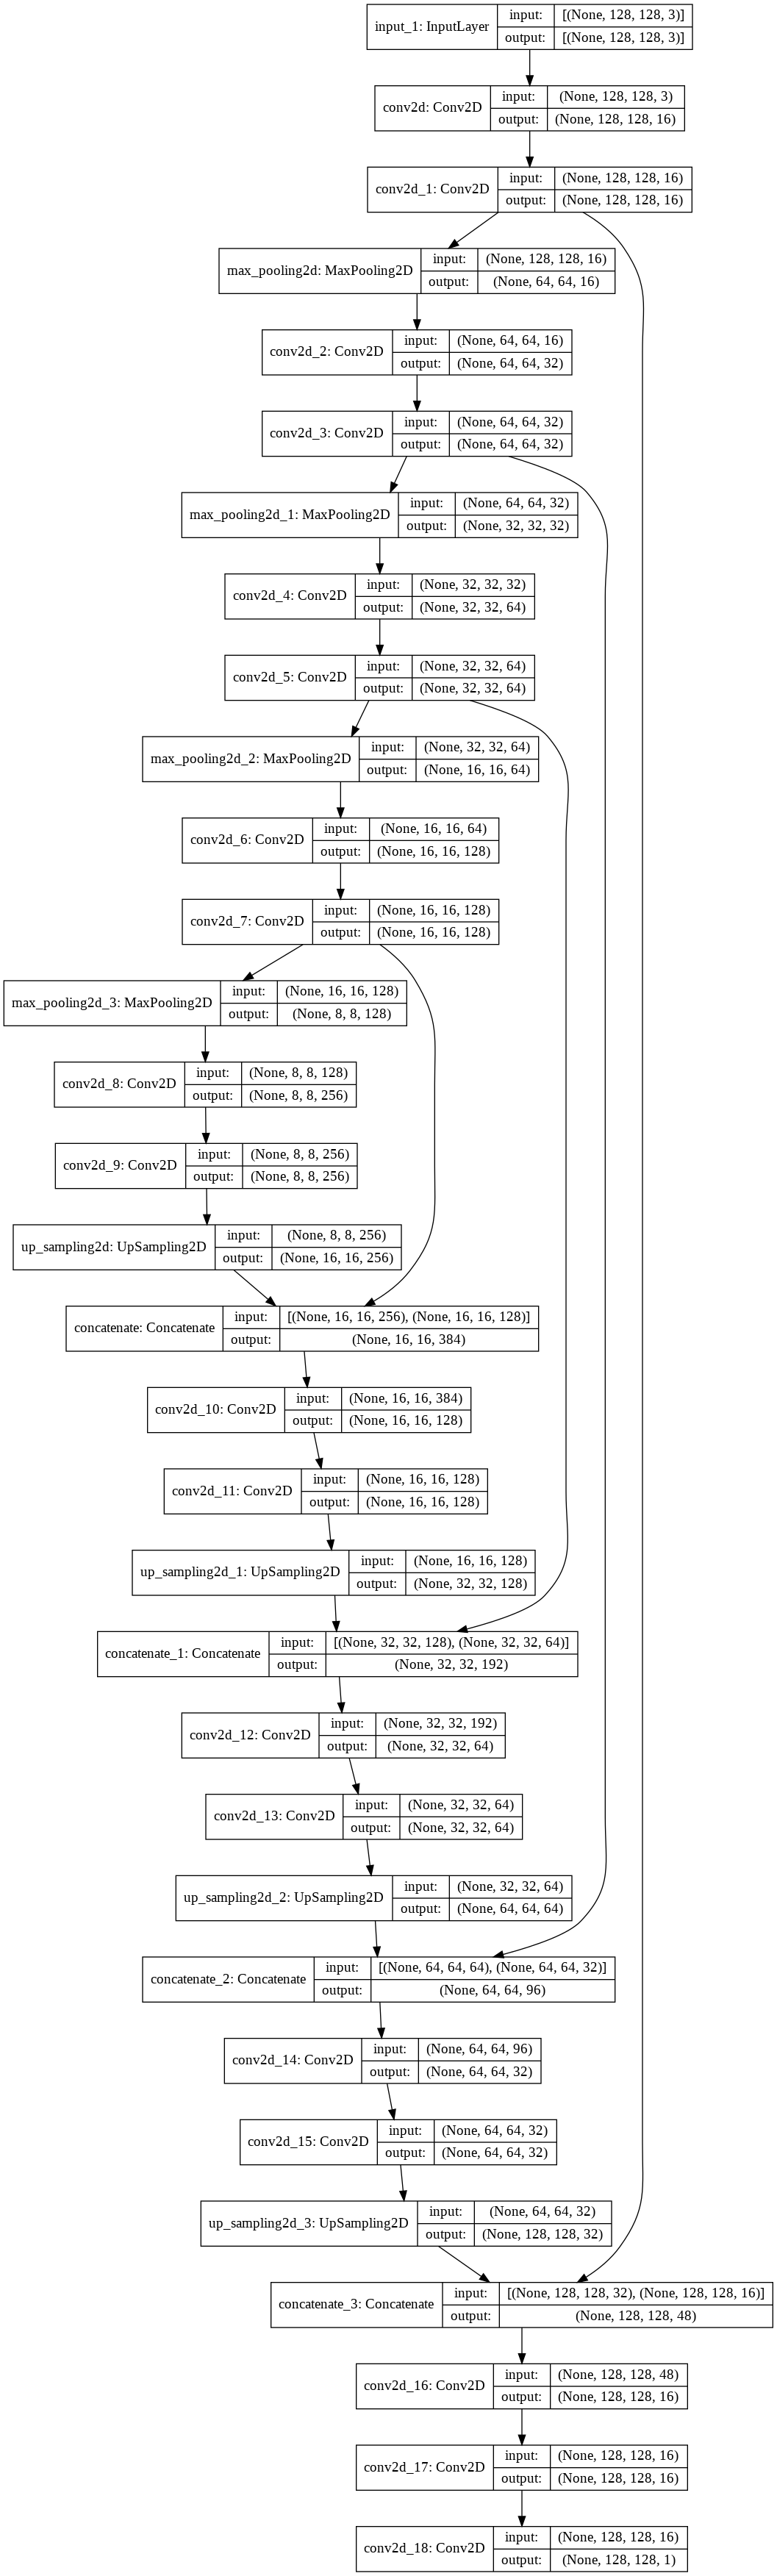

In [8]:
keras.utils.plot_model(m.model, show_shapes=True)

In [9]:
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, batch_size = 8, image_size = 128):
    self.batch_size = batch_size
    self.image_size = image_size

  def load(self, rgb_file, depth_file):
    image = cv2.imread(rgb_file)
    image = cv2.resize(image, (self.image_size, self.image_size)) # resize...
    depth = cv2.imread(depth_file, -1)
    depth = cv2.resize(depth, (self.image_size, self.image_size)) 

    image_normalized = image/np.max(image)
    depth_normalized = depth/np.max(depth) # double check the depth images!
    return image_normalized, depth_normalized

  def load_all(self, rgb_files, depth_files):
      images = []
      depths = []
      for i in range(len(rgb_files)):
          img, dpth = self.load(rgb_files[i], depth_files[i])
          images.append(img)
          depths.append(dpth)

      return np.array(images), np.array(depths)

In [10]:
# Get file names
rgbtest = '/content/rgb/'
dptest = '/content/depth/'

rgb_images = os.listdir(rgbtest)
rgb_images.sort()
rgb_images = [str(rgbtest) + file for file in rgb_images]
depth_images = os.listdir(dptest)
depth_images.sort()
depth_images = [str(dptest) + file for file in depth_images]

test_size = 100
rgb_images_test = rgb_images[:test_size]
depth_images_test = depth_images[:test_size]

rgb_images_train = rgb_images[test_size:]
depth_images_train = depth_images[test_size:]

# Load data:

load_data = DataGenerator()

X_train, y_train = load_data.load_all(rgb_files=rgb_images_train, 
                                      depth_files=depth_images_train)

X_test, y_test = load_data.load_all(rgb_files=rgb_images_test, 
                                  depth_files=depth_images_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(506, 128, 128, 3) (506, 128, 128)
(100, 128, 128, 3) (100, 128, 128)


In [11]:
m.model.compile(optimizer='adam', loss='mse')
m.model.fit(X_train, y_train, batch_size=8, epochs=5, validation_split=0.2)

Epoch 1/5
51/51 [==============================] - 73s 1s/step - loss: 0.0901 - val_loss: 0.0342
Epoch 2/5
51/51 [==============================] - 72s 1s/step - loss: 0.0487 - val_loss: 0.0330
Epoch 3/5
51/51 [==============================] - 72s 1s/step - loss: 0.0455 - val_loss: 0.0329
Epoch 4/5
51/51 [==============================] - 71s 1s/step - loss: 0.0418 - val_loss: 0.0333
Epoch 5/5
51/51 [==============================] - 71s 1s/step - loss: 0.0393 - val_loss: 0.0290


0.48496258


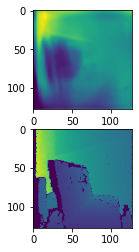

In [13]:
preds = m.model.predict(X_test[0:10])
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[0]*255)
print(np.max(prds1))